In [1]:
!nvidia-smi

Sun Oct  4 18:02:39 2020       

+-----------------------------------------------------------------------------+

| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |

|-------------------------------+----------------------+----------------------+

| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |

| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |

|===============================+======================+======================|

|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |

| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |

+-------------------------------+----------------------+----------------------+

                                                                               

+-----------------------------------------------------------------------------+

| Processes:                                                       GPU Memor

In [2]:
!pip install tensorflow-gpu






ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)

ERROR: No matching distribution found for tensorflow-gpu


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sp500-daily-19862018/spx.csv


In [4]:
df = pd.read_csv("/kaggle/input/sp500-daily-19862018/spx.csv", parse_dates=['date'], index_col='date')

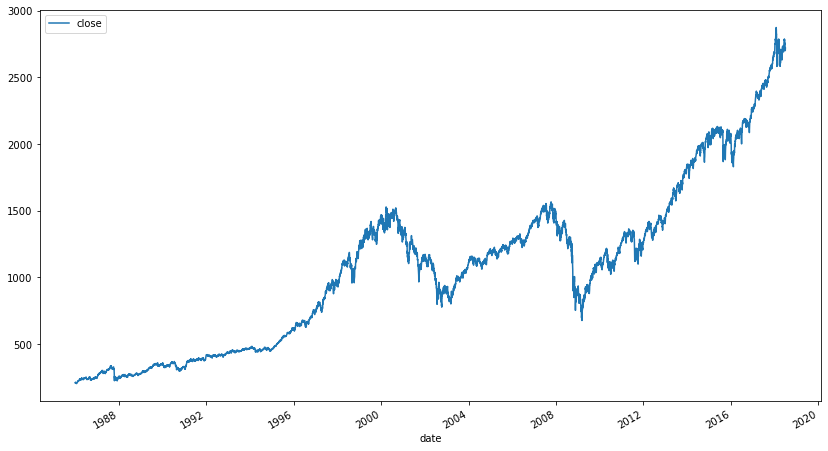

In [5]:
df.plot(figsize=(14,8))
plt.show()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 8192 entries, 1986-01-02 to 2018-06-29

Data columns (total 1 columns):

 #   Column  Non-Null Count  Dtype  

---  ------  --------------  -----  

 0   close   8192 non-null   float64

dtypes: float64(1)

memory usage: 128.0 KB


In [7]:
df.describe()

,close
count,8192.000000
mean,1070.897411
std,616.714534
min,203.490000
25%,458.632500
50%,1106.435000
75%,1388.132500
max,2872.870000


### Data Preparation

In [8]:
### Using 95% as training data

# We'll look back 30 days of historical data to learn past trend. 
# Setting shuffle to False to retain the time series
TIMESTEPS = 30            

train_data, test_data = train_test_split(df, train_size=0.95, shuffle=False)
train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)
train_data.shape, test_data.shape

((7782, 1), (410, 1))

In [9]:
train_data

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97
...,...
2016-11-04,2085.18
2016-11-07,2131.52
2016-11-08,2139.56


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 7782 entries, 1986-01-02 to 2016-11-10

Data columns (total 1 columns):

 #   Column  Non-Null Count  Dtype  

---  ------  --------------  -----  

 0   close   7782 non-null   float64

dtypes: float64(1)

memory usage: 121.6 KB


In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 410 entries, 2016-11-11 to 2018-06-29

Data columns (total 1 columns):

 #   Column  Non-Null Count  Dtype  

---  ------  --------------  -----  

 0   close   410 non-null    float64

dtypes: float64(1)

memory usage: 6.4 KB


In [12]:
def getScaledData(method='standard', train_df=None, test_df=None, feature_col='feature'):
    if method == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    scaler = scaler.fit(train_df[[feature_col]])
    train_df['scaled_'+feature_col] = scaler.transform(train_df[[feature_col]])
    test_df['scaled_'+feature_col] = scaler.transform(test_df[[feature_col]])
    return train_df, test_df, scaler
    
def createDataset(df, lookback=30, feature_col=None):
    data_x, data_y = [], []
    for i in range(lookback, len(df)):
        data_x.append(df.iloc[i-lookback:i][[feature_col]].values)
        data_y.append(df.iloc[i][feature_col])
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    return data_x, data_y

We will fit a separate scaler for training (& validation set) and test set.
We are assuming that the data used in training is normal with no anomalies and hence will fit a scaler from training dataset and will extract a subset of data as validation. Since validation data is also normal, this will be used for validation during training process.

In [13]:
train_df, test_df, scaler = getScaledData('standard', train_data, test_data, 'close')
train_df.shape, test_df.shape

((7782, 2), (410, 2))

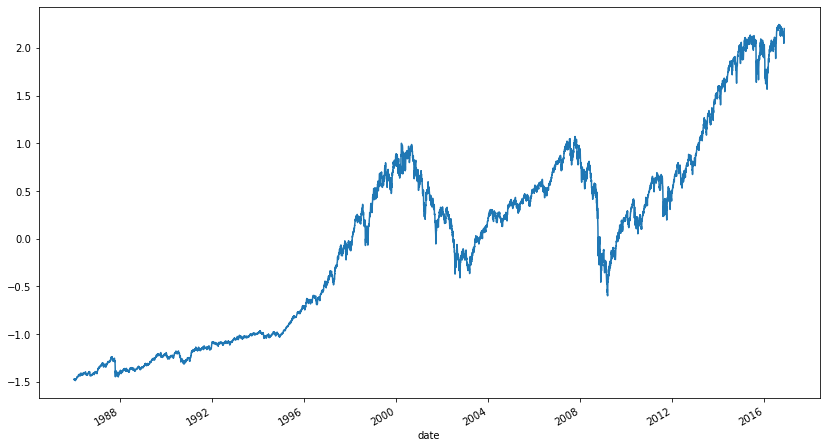

In [14]:
train_df['scaled_close'].plot(figsize=(14,8))
plt.show()

In [15]:
train_x, train_y = createDataset(train_df, TIMESTEPS, 'scaled_close')
test_x, test_y = createDataset(test_df, TIMESTEPS, 'scaled_close')

In [16]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((7752, 30, 1), (7752,), (380, 30, 1), (380,))

The LSTM autoencoder will get train_x as input and will return an output with the same shape that will be compared with this input.

1. ### Model configuration & training 

Each LSTM unit cell has an internal state called as cell state and an output called as hidden state.
We set return sequences to true to return hidden state for each timestep. This is set to true when 
stacking multiple LSTM layers where each LSTM layer receives a 3-dimensional input sequence or while returning a sequence of outputs.
We'll be using Timedistributed Layer to wrap output of dense layer for every timestep to return an output sequence.

We use RepeatVector to repeat our vector output returned by last layer in encoder LSTM. This vector is repeated TIMESTEPS time since the 1st layer in the decoder - decoder_lstm requires a 3-D input compressed sequence.


In [17]:

LSTM_units = 64
model = keras.Sequential()
model.add(LSTM(LSTM_units, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=False,name='encoder_lstm'
              ))
model.add(Dropout(0.2, name='encoder_dropout'))
model.add(RepeatVector(train_x.shape[1], name='decoder_repeater'))
model.add(LSTM(LSTM_units, return_sequences=True, name='decoder_lstm'))
model.add(Dropout(rate=0.2, name='decoder_dropout'))
model.add(TimeDistributed(Dense(train_x.shape[2],name='decoder_dense_output')))

model.compile(loss='mae', optimizer='adam')

In [18]:
model.summary()

Model: "sequential"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


encoder_lstm (LSTM)          (None, 64)                16896     

_________________________________________________________________

encoder_dropout (Dropout)    (None, 64)                0         

_________________________________________________________________

decoder_repeater (RepeatVect (None, 30, 64)            0         

_________________________________________________________________

decoder_lstm (LSTM)          (None, 30, 64)            33024     

_________________________________________________________________

decoder_dropout (Dropout)    (None, 30, 64)            0         

_________________________________________________________________

time_distributed (TimeDistri (None, 30, 1)             65        


Total params: 49,985

Trainable params: 49,985

Non-trainable params: 0

_________________________________

In [19]:
%time history = model.fit(train_x, train_x, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10

218/218 [==============================] - 2s 8ms/step - loss: 0.1743 - val_loss: 0.2837

Epoch 2/10

218/218 [==============================] - 1s 5ms/step - loss: 0.1053 - val_loss: 0.1950

Epoch 3/10

218/218 [==============================] - 1s 5ms/step - loss: 0.1079 - val_loss: 0.1230

Epoch 4/10

218/218 [==============================] - 1s 5ms/step - loss: 0.1168 - val_loss: 0.2726

Epoch 5/10

218/218 [==============================] - 1s 5ms/step - loss: 0.1358 - val_loss: 0.2717

Epoch 6/10

218/218 [==============================] - 1s 5ms/step - loss: 0.1433 - val_loss: 0.1982

Epoch 7/10

218/218 [==============================] - 1s 6ms/step - loss: 0.1261 - val_loss: 0.1504

Epoch 8/10

218/218 [==============================] - 1s 5ms/step - loss: 0.1334 - val_loss: 0.1223

Epoch 9/10

218/218 [==============================] - 1s 5ms/step - loss: 0.1317 - val_loss: 0.1407

Epoch 10/10

218/218 [==============================] - 1s 5ms/step - loss: 0.1323

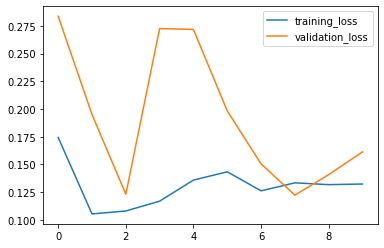

In [20]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

### Finding Anomalies

Plotting the distribution of error for train set to set a threshold for reconstruction error beyond which the input record will be labelled as anomaly.

In [21]:
reconstructed = model.predict(train_x)
reconstructed.shape, train_x.shape

((7752, 30, 1), (7752, 30, 1))

In [22]:
# Reconstruction error - MAE for each sample

mae_loss = np.mean(np.abs(reconstructed - train_x), axis=1)
mae_loss.shape

(7752, 1)

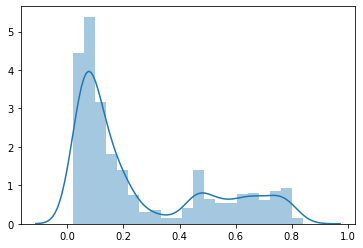

In [23]:
sns.distplot(mae_loss[:,0])
plt.show()

Setting a threshold to label anomalies

In [24]:
THRESHOLD = 0.65

In [25]:
test_reconstruction = model.predict(test_x)
test_reconstruction.shape

(380, 30, 1)

In [26]:
# MAE for reconstruction on test data
test_mae_loss = np.mean(np.abs(test_x - test_reconstruction), axis=1)
test_mae_loss.shape

(380, 1)

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 410 entries, 2016-11-11 to 2018-06-29

Data columns (total 2 columns):

 #   Column        Non-Null Count  Dtype  

---  ------        --------------  -----  

 0   close         410 non-null    float64

 1   scaled_close  410 non-null    float64

dtypes: float64(2)

memory usage: 9.6 KB


### Observing the anomalies

In [28]:
# Setting index after N timesteps from past in test_df
anomaly_results_df = test_df[TIMESTEPS:][['close', 'scaled_close']].copy()
anomaly_results_df.index = test_df[TIMESTEPS:].index

# Including reconstructed predictions
anomaly_results_df['deviation'] = test_mae_loss
anomaly_results_df['threshold'] = THRESHOLD
anomaly_results_df['anomaly'] = anomaly_results_df['deviation'].apply(lambda dev: 1 if dev > THRESHOLD else 0)


anomalies = anomaly_results_df[anomaly_results_df['anomaly'] == 1]
anomalies.shape

(8, 5)

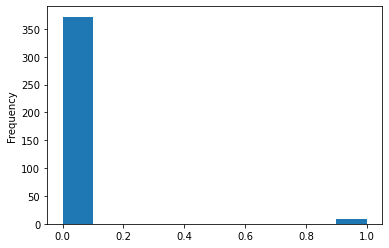

In [29]:
anomaly_results_df['anomaly'].plot(kind='hist')
plt.show()

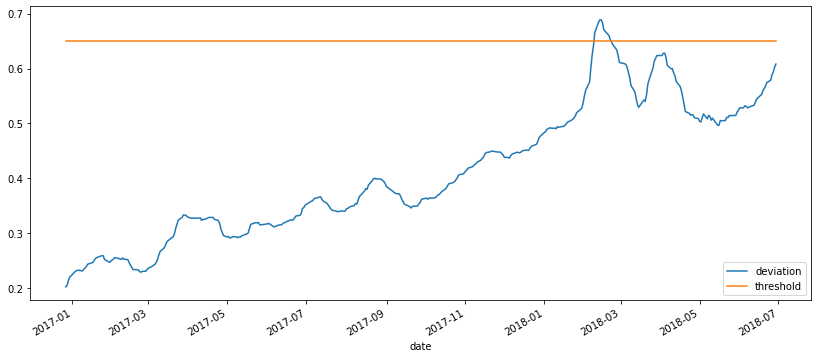

In [30]:
anomaly_results_df[['deviation', 'threshold']].plot(figsize=(14, 6))
plt.show()

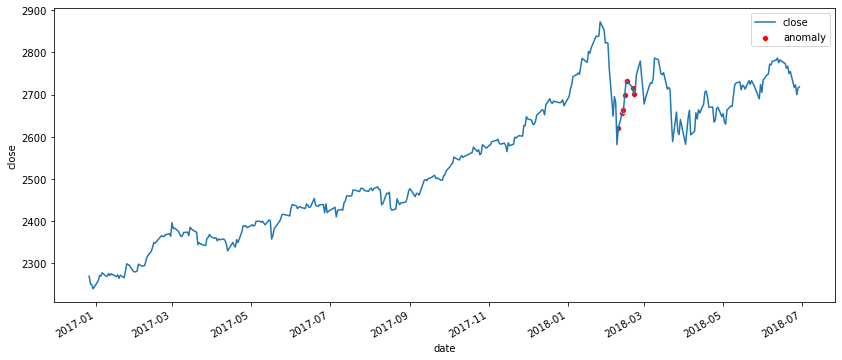

In [31]:
anomaly_results_df[['close']].plot(figsize=(14, 6))
sns.scatterplot(anomalies.index, anomalies['close'],label='anomaly',color='red')
plt.show()